在神经网络中，一个重要内容就是进行参数学习，而参数学习离不开求导。

现在大部分深度学习架构都有自动求导的功能，torch.autograd包 就是用来自动求导的。

torch.autograd 包为张量上 所有的操作 提供了自动求导功能

1、计算图

在整个前向计算过程中，PyTorch采用 动态计算图 的形式进行组织，且在每次 前向传播时重新构建。

其他深度学习架构，如TensorFlow、Keras 一般为静态图。

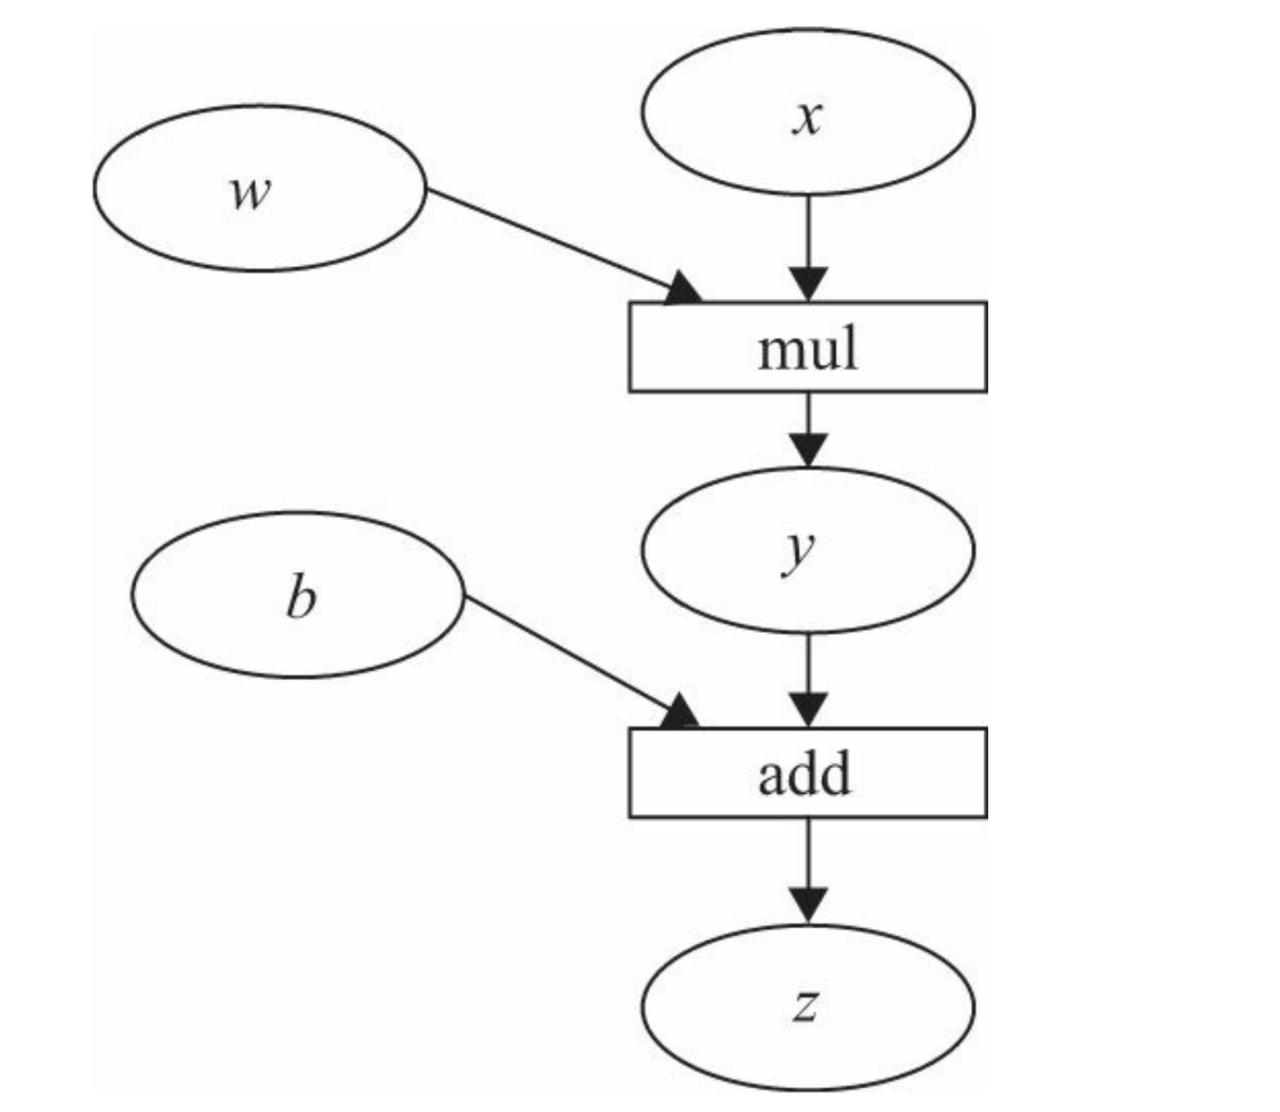

上面的计算图中，圆形表示变量，矩阵表示算子，这些变量及算子就构成了一个完整的前向传播过程

计算图是一种有向无环图，用图形方式来表示算子与变量之间的关系，直观高效。 

2、叶子节点、非叶子节点、根节点

叶子节点 ： x、w、b 为叶子节点，它们是用户创建的变量，不依赖于其他变量

非叶子节点 ： y、z 为非叶子节点，它们是通过计算得到的变量

根节点 ：  z 为根节点，它之后不会再有后续的运算，我们一般让根节点来执行 反向传播 .backward()

3、反向传播

1）叶子节点（Leaf Node）的 Tensor，需要用 requires_grad 指定是否记录对其的操作/运算，以便之后通过 反向传播 求梯度。

请观察如下代码中，叶子结点与 非叶子结点的 requires_grad  与 梯度

叶子结点如果需要求导，requires_grad 需设置为 True，然后与之有依赖关系的非叶子结点，requires_grad 会自动置为True
（一般网络中的参数 为 torch.nn.Parameter 对象，requires_grad属性默认为 True 
torch.nn.Parameter 与 torch.Tensor） 

自动求导只会求叶子结点的梯度，不会求非叶子结点的梯度。确切的来说，非叶子结点的梯度值 只作为求叶子结点梯度 的过程值（非叶子结点 链式求导中的过程值），它并不会被记录下来。 因为非叶子结点的值是计算出来的，是不需要被更新的，所以不需要记录它们的梯度

In [ ]:
import torch

# 创建两个张量作为叶子节点，并设置 requires_grad=True
x = torch.tensor([2.0], requires_grad=True)
y = torch.tensor([3.0], requires_grad=True)

# 创建一个计算图，包括叶子节点和非叶子节点
z = x * y  # 非叶子节点
w = z + torch.tensor([1.0])  # 非叶子节点

# 查看叶子节点和非叶子节点的 requires_grad 属性
print('x 的 requires_grad 属性:', x.requires_grad)
print('y 的 requires_grad 属性:', y.requires_grad)
print('z 的 requires_grad 属性:', z.requires_grad)
print('w 的 requires_grad 属性:', w.requires_grad)

# 对 w 进行反向传播
w.backward()

# 查看叶子节点和非叶子节点的梯度
print('x 的梯度:', x.grad)
print('y 的梯度:', y.grad)
print('z 的梯度:', z.grad)
print('w 的梯度:', w.grad)

2）通过运算创建的 非叶子节点 tensor，会自动被赋予 grad_fn 属性。该属性表示梯度函数。叶子节点的 grad_fn 为 None。 

In [ ]:
import torch

# 创建叶子节点张量
x = torch.tensor([2.0], requires_grad=True)
y = torch.tensor([3.0], requires_grad=True)

# 创建非叶子节点张量，通过运算生成
z = x * y

# 查看叶子节点和非叶子节点的 grad_fn 属性
print('x 的 grad_fn:', x.grad_fn)
print('y 的 grad_fn:', y.grad_fn)
print('z 的 grad_fn:', z.grad_fn)

3）如下例子中，根节点 tensor 就是 loss，我们会让 loss 执行反向传播，一般执行步骤如下：

通过 optimizer.zero_grad() 清空叶子节点的梯度，否则，多次调用 optimizer.step() ，叶子节点梯度会进行累加。 

调用 loss.backward() 方法，计算每一个叶子节点的梯度 ，并存储在它们各自的 .grad 属性中

调用 optimizer.step() ，会根据优化器设置的具体算法和学习率，利用存储在叶子节点的 .grad 属性中的梯度，来更新叶子节点（即模型的参数）

for epoch in range(epochs):

    model.train()
    for imgs, labels in train_loader        :
        # train
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

4）代码举例

In [ ]:
import torch

# 输入张量 x， require_grad 属性默认为 False
x = torch.Tensor([2])

# 初始化 权重参数w, 偏移量b，并设置 require_grad 属性为 True, 为自动求导
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

# 实现向前传播
y = torch.mul(w, x)
z = torch.add(y, b)

# 分别查看叶子节点 x, w, b 和 非叶子节点 y、z 的require_grad属性
print(x.requires_grad, w.requires_grad, b.requires_grad)  # False True True
print(y.requires_grad, z.requires_grad )  # True True

# 查看各节点是否为叶子节点
print(x.is_leaf, w.is_leaf, b.is_leaf, y.is_leaf, z.is_leaf)  # True True True False False

# 分别查看 叶子节点 和 非叶子节点 的 grad_fn 属性
print(x.grad_fn, w.grad_fn, b.grad_fn)   # None None None
print(y.grad_fn, z.grad_fn)   # <MulBackward0 object at 0x7f8ac1303910> <AddBackward0 object at 0x7f8ac1303070>

# 反向传播计算梯度
z.backward()

# 查看叶子节点的梯度，x是叶子节点但它无须求导，故其梯度为None
print(w.grad,b.grad,x.grad)  # tensor([2.]) tensor([1.]) None

# 非叶子节点的梯度，执行backward之后，会自动清空
print(y.grad,z.grad)  # None None

4、Autograd 代码举例 

以下代码实现 ： 机器学习 回归问题举例，使用 backward() 反向传播自动求导，并手动更新参数

1）先来造一批数据，作为样本数据 x 和 标签值y

In [ ]:
import torch
import matplotlib.pyplot as plt


torch.manual_seed(100)

# 生成 x坐标数据，形状为 100 x 1
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)

# 生成 y坐标数据，，形状为 100 x 1，加上一些噪声
y = 3 * x.pow(2) + 2 + 0.2 * torch.rand(x.size())

# 把tensor数据转换为numpy数据，并可视化
plt.scatter(x.numpy(), y.numpy())
plt.show()

2）定义一个模型 y = wx +b, 我们要学习出 w 和 b 的值，用来拟合 x 和 y

In [ ]:
# 初始化权重参数，参数 w、b 为需要学习的，故需要设置参数 requires_grad=True
w = torch.randn(1, 1, dtype=torch.float, requires_grad=True)
b = torch.zeros(1, 1, dtype=torch.float, requires_grad=True)
print(w)  # tensor([[1.1046]], requires_grad=True)
print(b)  # tensor([[0.]], requires_grad=True)

lr = 0.001 # 学习率

for i in range(800):

    # 向前传播，得到预测的y值，记为 y_pred
    y_pred = w * x.pow(2) + b

    # 定义损失函数
    loss = (y - y_pred) ** 2
    loss = loss.sum()

    # 反向传播，自动计算梯度，存放在 grad 属性中
    loss.backward()

    # 手动更新参数，需要用torch.no_grad(), 使上下文环境中切断自动求导的计算
    with torch.no_grad():

        # 更新参数
        w -= lr * w.grad
        b -= lr * b.grad

        # 梯度清零
        w.grad.zero_()
        b.grad.zero_()

print(w)  # tensor([[2.9668]], requires_grad=True)
print(b)  # tensor([[2.1138]], requires_grad=True)

3）可视化一下，红色曲线是预测结果 ，蓝色点是 真实值

In [ ]:
plt.plot(x.numpy(), y_pred.detach().numpy(),'r-',label='predict')#predict
plt.scatter(x.numpy(), y.numpy(),color='blue',marker='o',label='true') # true data
plt.xlim(-1,1)
plt.ylim(2,6)
plt.legend() 
plt.show()